In [1]:
import pybnesian as pbn
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import timeit
import pickle
import os
from tqdm.contrib import tenumerate
import seaborn as sns
import matplotlib.pyplot as plt

/home/juan/miniconda3/envs/pcspbn/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
try:
    os.mkdir('./results/')
except:
    pass

try:
    os.mkdir('./results/synthetic/')
except:
    pass

try:
    os.mkdir('./results/synthetic/ablation_execution_times/')
except:
    pass

In [ ]:
def generate_Z_mixed(N, Dz, cont_discrete_ratio=0.5, num_categories=5, seed=None):
    rng = np.random.default_rng(seed)
    D_cont = int(Dz * cont_discrete_ratio)
    D_disc = Dz - D_cont

    Z_cont = rng.standard_normal((N, D_cont))

    Z_disc = np.zeros((N, D_disc), dtype=int)
    for d in range(D_disc):
        probs = rng.dirichlet(np.ones(num_categories))
        Z_disc[:, d] = rng.choice(num_categories, size=N, p=probs)

    return Z_cont, Z_disc

def generate_experiment_unconditionally_dependent_mixed(N=1000, Dz=6, cont_discrete_ratio=0.5, m=5, seed=None):
    rng = np.random.default_rng(seed)

    # X ~ Uniform{0, ..., m-1}
    X = rng.integers(0, m, size=N)

    # Y ~ Uniform(X, X+2)
    Y = rng.uniform(X, X + 2.0)

    # Z as before (conditionally independent from X, Y)
    Z_cont, Z_disc = generate_Z_mixed(N, Dz, cont_discrete_ratio, seed=seed)

    return X, Y, Z_cont, Z_disc

def generate_Z_discrete(N, Dz, cont_discrete_ratio=0.5, num_categories=5, seed=None):
    rng = np.random.default_rng(seed)
    Z_disc = np.zeros((N, Dz), dtype=int)
    for d in range(Dz):
        probs = rng.dirichlet(np.ones(num_categories))
        Z_disc[:, d] = rng.choice(num_categories, size=N, p=probs)

    return Z_disc

def generate_experiment_unconditionally_dependent_discrete(N=1000, Dz=6, cont_discrete_ratio=0.5, m=5, seed=None):
    rng = np.random.default_rng(seed)

    # X ~ Uniform{0, ..., m-1}
    X = rng.integers(0, m, size=N)

    # Y ~ Uniform(X, X+2)
    Y = rng.binomial(X, 0.5)

    # Z as before (conditionally independent from X, Y)
    Z = generate_Z_discrete(N, Dz, cont_discrete_ratio, seed=seed)

    return X, Y, Z

#### Ablation study

In [ ]:
n_trials = 50
timings_pbn = []

for seed, num_samples in tenumerate(range(200, 2001, 100)):
    X, Y, Z_cont, Z_disc = generate_experiment_unconditionally_dependent_mixed(num_samples, 2, 0.5, 5, seed=333)
    df = pd.DataFrame([X, Y] + Z_cont.T.tolist() + Z_disc.T.tolist()).T
    for i in range(len(df.columns)):
        if i == 0 or i > (len(df.columns) - 2) // 2 + 1:
            df.iloc[:, i] = df.iloc[:, i].astype(str).astype('category')
    x = str(df.columns[0])
    y = str(df.columns[1])
    z = [str(x) for x in df.columns[2:]]
    
    time_pbn = timeit.repeat('pbn_knncmi = pbn.MixedKMutualInformation(df=df, k=len(df)//10, scaling="normalized_rank", adaptive_k=True, shuffle_neighbors=5, samples=100, gamma_approx=True, tree_leafsize=1); pbn_knncmi.pvalue(x, y, z)', repeat=1, number=n_trials, globals=globals())
    timings_pbn.append(time_pbn)

# Baseline
# with open('./results/synthetic/ablation_execution_times/mixed_0.pkl', "wb") as f: 
#     pickle.dump(timings_pbn, f)

# Query only Z
# mixed_knncmi_ablation.cpp mi_general()
# with open('./results/synthetic/ablation_execution_times/mixed_1.pkl', "wb") as f: 
#     pickle.dump(timings_pbn, f)

# Bi-level tree
# vptree_ablation.cpp build_vptree()
# with open('./results/synthetic/ablation_execution_times/mixed_2.pkl', "wb") as f: 
#     pickle.dump(timings_pbn, f)

# VPTree recycling Z
# mixed_knncmi_ablation.cpp shuffled_pvalue()
# with open('./results/synthetic/ablation_execution_times/mixed_3.pkl', "wb") as f: 
#     pickle.dump(timings_pbn, f)

# Buckets --tree_leafsize= 1 or 16 in MixedKMutualInformation constructor
# with open('./results/synthetic/ablation_execution_times/mixed_4.pkl', "wb") as f:
#     pickle.dump(timings_pbn, f)

# All optimizations
# with open('./results/synthetic/ablation_execution_times/mixed_5.pkl', "wb") as f:
#     pickle.dump(timings_pbn, f)

100%|██████████| 19/19 [05:46<00:00, 18.25s/it]


In [ ]:
n_trials = 50
timings_pbn = []

for seed, num_samples in tenumerate(range(200, 2001, 100)):
    X, Y, Z = generate_experiment_unconditionally_dependent_discrete(num_samples, 2, 0.5, 5, seed=333)
    df = pd.DataFrame([X, Y] + Z.T.tolist()).T
    for i in range(len(df.columns)):    
        df.iloc[:, i] = df.iloc[:, i].astype(str).astype('category')
    x = str(df.columns[0])
    y = str(df.columns[1])
    z = [str(x) for x in df.columns[2:]]
    
    time_pbn = timeit.repeat('pbn_knncmi = pbn.MixedKMutualInformation(df=df, k=len(df)//10, scaling="normalized_rank", adaptive_k=True, shuffle_neighbors=5, samples=100, gamma_approx=True, tree_leafsize=1); pbn_knncmi.pvalue(x, y, z)', repeat=1, number=n_trials, globals=globals())
    timings_pbn.append(time_pbn)

# Baseline
# with open('./results/synthetic/ablation_execution_times/discrete_0.pkl', "wb") as f: 
#     pickle.dump(timings_pbn, f)

# Query only Z
# mixed_knncmi_ablation.cpp mi_general()
# with open('ablation./results/synthetic/ablation_execution_times_execution_times/discrete_1.pkl', "wb") as f: 
#     pickle.dump(timings_pbn, f)

# Bi-level tree
# vptree_ablation.cpp build_vptree()
# with open('./results/synthetic/ablation_execution_times/discrete_2.pkl', "wb") as f: 
#     pickle.dump(timings_pbn, f)

# VPTree recycling Z
# mixed_knncmi_ablation.cpp shuffled_pvalue()
# with open('./results/synthetic/ablation_execution_times/discrete_3.pkl', "wb") as f: 
#     pickle.dump(timings_pbn, f)

# Buckets --tree_leafsize= 1 or 16 in MixedKMutualInformation constructor, and vptree_ablation.cpp build_vptree()
# with open('./results/synthetic/ablation_execution_times/discrete_4.pkl', "wb") as f:
#     pickle.dump(timings_pbn, f)

# Caching
# vptree_ablation.cpp query() and count_ball_subspaces()
# with open('./results/synthetic/ablation_execution_times/discrete_5.pkl', "wb") as f: 
#     pickle.dump(timings_pbn, f)

# All optimizations
# with open('./results/synthetic/ablation_execution_times/discrete_6.pkl', "wb") as f:
#     pickle.dump(timings_pbn, f)


100%|██████████| 19/19 [20:51<00:00, 65.85s/it] 


In [3]:
n_trials = 50
legend_dict = {
    0:'Baseline',
    1:r'Query only $\mathbf{Z}$',
    2:'Bi-level VP-tree',
    3:r'$\mathbf{Z}$ VP-tree recycling',
    4:'Bucket leaves',
    5:'All optimizations'
               }

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


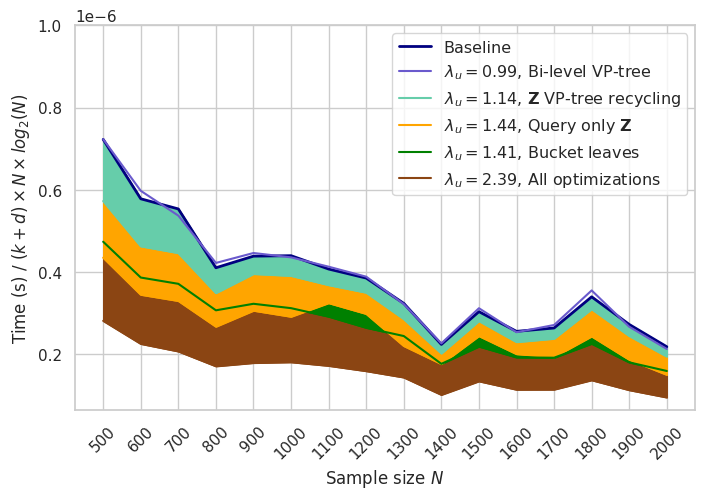

In [4]:
sns.set_theme()
sns.set_style("whitegrid")
fig = plt.figure(figsize=(8, 5))
nlogn = [(i//10 + 4) * i * np.log2(i) for i in range(500, 2001, 100)]
x = np.arange(len(nlogn))
y_curves = []

palette = [
    "saddlebrown",         # best
    "green",   
    "orange",
    "mediumaquamarine",
    "slateblue",
    "navy"     # worst
][::-1]

# Plot and collect curves
for i, idx in enumerate([0, 2, 3, 1,4, 5]):
    with open(f"./results/synthetic/ablation_execution_times/mixed_{idx}.pkl", "rb") as f:
        y = (np.mean(pickle.load(f)[3:], axis=1) / n_trials) / nlogn
        if i == 0:
            ax = sns.lineplot(x=x, y=y, label=legend_dict[idx], color=palette[i], linewidth=2)
        else:
            speedup = np.mean(y_curves[0]/y)
            ax = sns.lineplot(x=x, y=y, label=fr'$\lambda_u = {speedup:.2f}$, {legend_dict[idx]}', color=palette[i], linewidth=1.5)
        y_curves.append(np.array(y))

for i in [0, 2, 3, 1,4, 5][::-1]:  # reverse order
    y = y_curves[i]
    
    color = ax.get_lines()[i].get_color()
    mask = (y <  y_curves[0])
    plt.fill_between(
        x,
        y,
        y_curves[0],
        where=mask,
        color=color,
        alpha=1,
    )

plt.xticks(ticks= [i for i,_ in enumerate(range(500, 2001, 100))], labels=[i for i in range(500, 2001, 100)], rotation=45)
plt.xlabel(r"Sample size $N$")
plt.ylabel("Time (s) / $(k + d) \\times N \\times log_{2}(N)$")
plt.legend(fontsize=11.5)
plt.ylim(top=1e-6)
plt.savefig('./results/synthetic/ablation_mixed.eps', format= 'eps', bbox_inches='tight')

In [5]:
legend_dict = {
    0:'Baseline',
    1:r'Query only $\mathbf{Z}$',
    2:'Bi-level VP-tree',
    3:r'$\mathbf{Z}$ VP-tree recycling',
    4:'Bucket leaves',
    5:'Query caching',
    6:'All optimizations'
               }

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


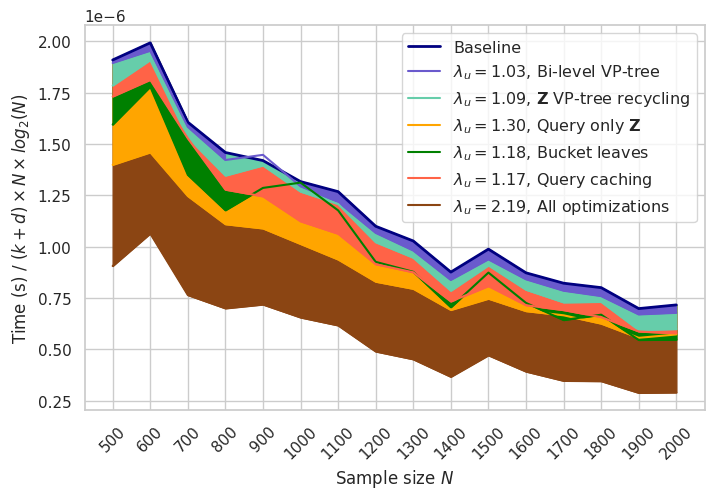

In [6]:
sns.set_theme()
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
nlogn = [(i//10 + 4) * i * np.log2(i) for i in range(500, 2001, 100)]
x = np.arange(len(nlogn))
y_curves = []
palette = [
    "saddlebrown",
    "tomato",
    "green",   # best
    "orange",
    "mediumaquamarine",
    "slateblue",
    "navy"     # worst
][::-1]

# Plot and collect curves
for i, idx in enumerate([0, 2, 3, 1,4, 5, 6]):
    with open(f"./results/synthetic/ablation_execution_times/discrete_{idx}.pkl", "rb") as f:
        y = (np.mean(pickle.load(f)[3:], axis=1) / n_trials) / nlogn
        if i == 0:
            ax = sns.lineplot(x=x, y=y, label=legend_dict[idx], color=palette[i], linewidth=2)
        else:
            speedup = np.mean(y_curves[0]/y)
            ax = sns.lineplot(x=x, y=y, label=fr'$\lambda_u = {speedup:.2f}$, {legend_dict[idx]}', color=palette[i], linewidth=1.5)
        y_curves.append(np.array(y))

for i in [0, 1, 2,5, 4, 3, 6][::-1]:  # reverse order
    y = y_curves[i]
    
    color = ax.get_lines()[i].get_color()
    mask = (y <  y_curves[0])
    plt.fill_between(
        x,
        y,
        y_curves[0],
        color=color,
        alpha=1,
        where=mask
    )


plt.xticks(ticks= [i for i,_ in enumerate(range(500, 2001, 100))], labels=[i for i in range(500, 2001, 100)], rotation=45)
plt.xlabel(r"Sample size $N$")
plt.ylabel("Time (s) / $(k + d) \\times N \\times log_{2}(N)$")
plt.legend(fontsize=11.5)
plt.savefig('./results/synthetic/ablation_discrete.eps', format='eps', bbox_inches='tight')